# Machine Learning #4 - Gözetimsiz Öğrenme, Kümeleme, K-Means Algoritması, Boyut Azaltma, Temel Bileşenler Analizi

Merhabalar, Machine Learning serimizin dördüncüsünde,
- Gözetimsiz öğrenme kavramını inceleyecek,
- Kümeleme yöntemini ve bu yöntemi içeren K-Means Algoritması'nı öğrenecek,
- Kümeleme yönteminin kritik konularından olan boyut azaltma ve Temel Bileşenler Analizi(PCA) kavramlarına değineceğiz.

Serinin ikinci yazısında yer alan şarap kalitesi veri setini kullanacağız, ancak bu kez etiketleme yapmadan, gözetimsiz öğrenme teknikleriyle veri setini inceleyeceğiz.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('winequality-red.csv')

Bu yazıda, serinin önceki yazılarından farklı bir öğrenme modeline, **gözetimsiz öğrenme**ye değineceğiz. **Gözetimsiz Öğrenme**, gözetimli öğrenmeden farklı olarak, verileri sebep-sonuç ya da giriş-çıkış şeklinde etiketlemeden, veri içerisinde var olan ilişkilerin ve yapıların öğrenilmesidir. 

Gözetimli öğrenmeden farklı olarak, bir eğitim verisine ihtiyacımız yoktur. Gözetimsiz öğrenme algroitması, eldeki veriyi yorumlar ve gruplar. Daha sonra da yeni gelen verinin hangi gruba ait olduğunu tahmin eder. Bu tahmini yaparken özelliklerinin o gruplardan hangisine daha çok benzediğini bulmaya çalışır, ancak veriler etiketli olmadığı için bu örneğin ne olduğuna dair bir yorum yapamaz. Bu yourumu uygulayıcıya bırakıyor olmasına rağmen, kolay görselleştirilebildiği için oldukça kullanışlıdır.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Kümeleme algoritması için tüm değerlerin non-null olması ve string barındırmaması önemlidir. Bir analitik uzayda uzaklık hesabına göre kümeleme yapılacağı için tüm değerlerimiz sayısal olmalıdır.

## K-Means Kümeleme Algoritması

**K-ortalama kümeleme** ya da **K-means kümeleme (K-means clustering)** yöntemi bir veri kümesini giriş parametresi olarak verilen K adet kümeye bölümlemektir. Amaç, gerçekleştirilen bölümleme işlemi sonunda elde edilen kümelerin, küme içi benzerliklerinin maksimum ve kümeler arası benzerliklerinin ise minimum olmasını sağlamaktır.

K-means algoritmasının çalışma mekanizmasına göre öncelikle her kümenin merkez noktasını veya ortalamasını temsil etmek üzere K adet nesne rastgele seçilir. Kalan diğer nesneler, kümelerin ortalama değerlerine olan uzaklıkları dikkate alınarak en benzer oldukları kümelere dahil edilir. Daha sonra, her bir kümenin ortalama değeri hesaplanarak yeni küme merkezleri belirlenir ve tekrar nesnelerin merkeze uzaklıkları incelenir. Herhangi bir değişim olmayıncaya kadar algoritma tekrarlamaya devam eder.

Algoritma temel olarak 4 aşamadan oluşur:

**1.Küme merkezlerinin belirlenmesi**

**2.Merkez dışındaki verilerin mesafelerine göre kümelendirilmesi**

**3.Yapılan kümelendirmeye göre yeni merkezlerin belirlenmesi (veya eski merkezlerin yeni merkeze kaydırılması)**

**4.Kararlı hale (stable state) gelinene kadar 2. ve 3. adımların tekrarlanması.**

<AxesSubplot:title={'center':'Quality Distribution Plot'}, xlabel='quality', ylabel='Density'>

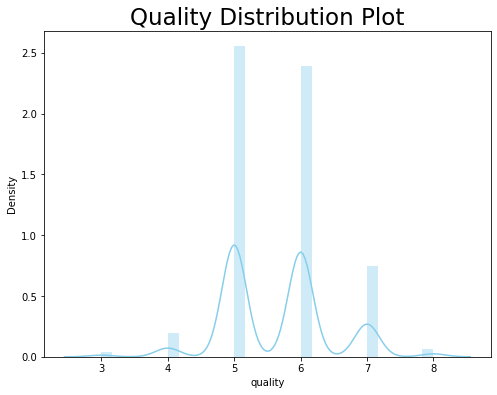

In [5]:
f0, ax = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot',fontsize=23)
sns.distplot(df['quality'], color='skyblue')

Bu veri setini kullandığımız bir önceki yazıda *df.describe()* metodunu kullanıp tablodaki sayısal değerlerleri yorumlayarak veri kümemizin büyük çoğunluğunun **quality** özelliğinin 5 ve 6 gibi değerlere sahp olduğunu söylemiştik. Bunu görsel olarak temsil etmek için *seaborn* kütüphanesiyle böyle bir görselleştirme yapabiliriz.

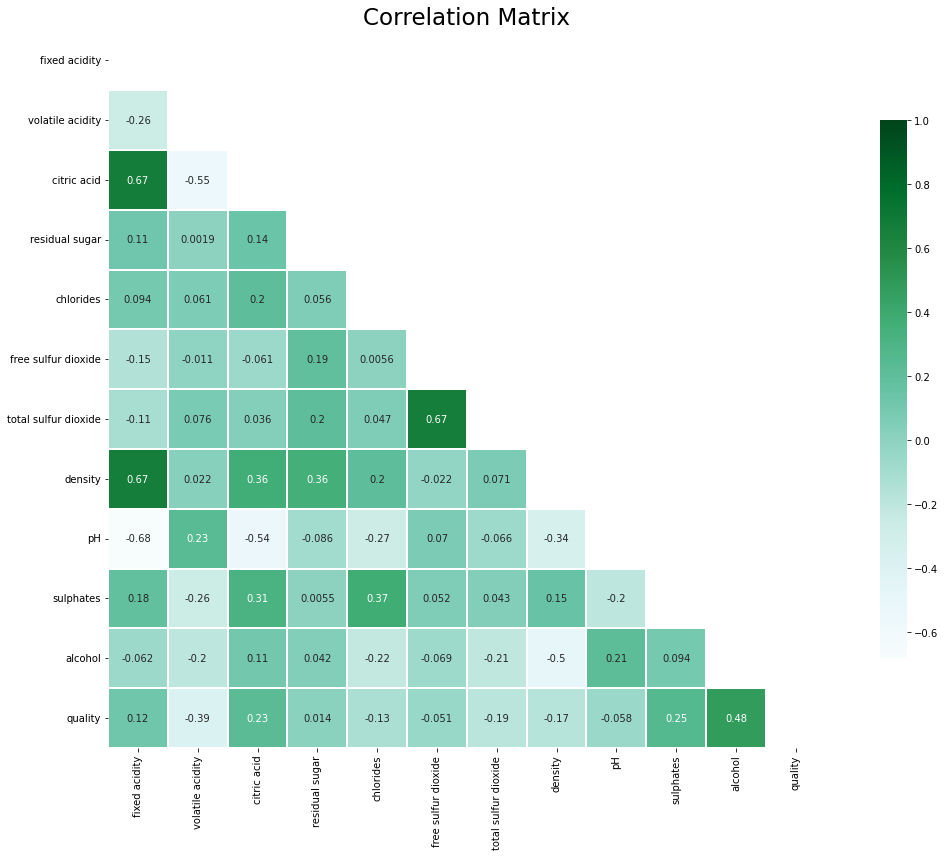

In [6]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation Matrix',fontsize=23)

sns.heatmap(df.corr(),linewidths=0.25, vmax=1.0, square=True, cmap="BuGn",
            linecolor='w', annot=True, mask=mask, cbar_kws={"shrink": .75})
f.tight_layout()

Korelasyon matrisi kavramına serinin önceki yazılarında değinmiştik. Bu kez, farklı bir yaklaşımla üst yarısı olmadan çizdirdik.

Text(0.5, 0.98, 'Positive and Negative Correlation Visualizations')

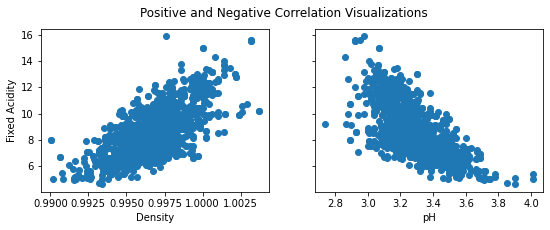

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].scatter(df["density"].values, df["fixed acidity"].values)
axs[0].set_xlabel('Density')
axs[0].set_ylabel('Fixed Acidity')
axs[1].scatter(df["pH"].values, df["fixed acidity"].values)
axs[1].set_xlabel('pH')
fig.suptitle('Positive and Negative Correlation Visualizations')

Korelasyonu görsel olarak daha net ifade edebilmek için,hedef değişkenimiz olan **"quality"** yerine daha güçlü korelasyona sahip değişkenleri seçtim. Korelasyon matrisinden de görebileceğimiz üzere **Fixed Acidity** özelliği, **Density** ile güçlü pozitif(0.67), **pH** ile de güçlü negatif(-0.68) bir korelasyona sahip.

## Centroid & Inertia Kavramları

K-Means kümeleme algoritmasının amacı, basitçe **k** adet kümenin ağırlık merkezlerini olabilecek en iyi şekilde seçmektir. Bu ağırlık merkezlerine **centroid** adı verilir. Olabilecek en iyi şekilde seçildiğinde, kayıp fonksiyonu(yani **inertia** değeri) minimize edilmiş olur.

***Not:*** Pek tabii ki, nihai amacımız sadece inertia'yı olabildiği kadar küçültmek değildir. Cluster veya centroid sayısını veri kümesinin eleman sayısına eşit belirlersek doğal olarak inertia sıfır olacaktır. Ama sonucunda verimiz kümelenmemiş olur. 

İdeal küme sayısının kaç olabileceği, **dirsek metodu** ile bulunur.

In [8]:
scaler = StandardScaler()
df_dropped = df.drop('quality', axis=1)
X = df_dropped.values[:, 1:]
scaled_x = scaler.fit_transform(X)

"quality" özelliğini veri kümemizdeki örneklerin özellikleri arasından çıkardık, ardından değerleri bir **X** değişkenine atadık ve skaler büyüklüklerin etkisini gidermek için **scale** ederek algoritmamızın veriyi anlamak için kullanacağı girdi setimizi hazırlamış olduk.

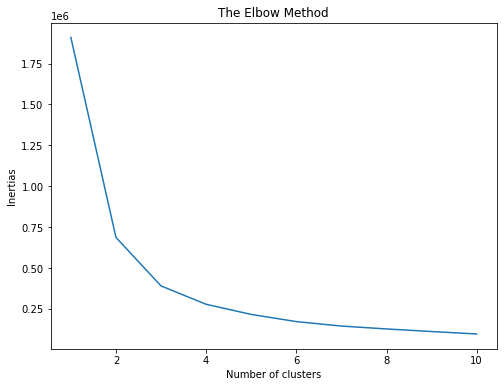

In [9]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
f3, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,11),inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

***Not:*** Optimum küme sayısını belirlerken, X değerlerinin **scale** edilmiş halini kullanmadık çünkü bu metod, model başarımını artırmak için yapacak olduğumuz sayısal bir düzeltmedir. Ancak öncesinde, bu veriyi kaç kümeye ayıracağımızı bilmek için, verinin kendisini incelemek isteriz, üzerinde oynama yapılmış halini değil.

Küme sayımızı **3** olarak belirleyebiliriz gibi duruyor, devamında **inertia** değerinin düşme hızı azalıyor.

In [10]:
model = KMeans(n_clusters=3)
training_points = scaled_x[:1000]
test_points = scaled_x[1000:]
model.fit(training_points)
labels = model.predict(test_points)

K-Means modelimiz, hazırlamış olduğumuz veri setinin ilk 1000 örneğini eğitim için kullanacak, diğer 500 örneği de ilk 1000 örnekten yaptığı çıkarımlara göre sınıflandıracak.

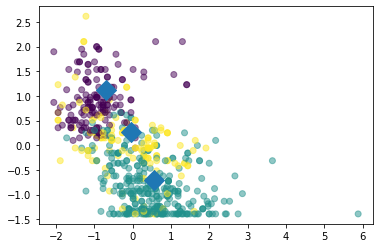

In [11]:
xs = test_points[:,0]
ys = test_points[:,1]

# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs, ys, c=labels, alpha=0.5)

# Assign the cluster centers: centroids
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x, centroids_y, marker='D',s=200)
plt.show()

Kümelerin ağırlık merkezlerini grafikte kare olarak görebilirsiniz. Bazı keskin örnekleri düzgün kümeleyebilmiş olsak da, renkler biraz karışık duruyor. Daha iyi performans için algoritmamıza nasıl yardımcı olabiliriz?

## Boyut Azaltma & PCA

Boyut azaltma, verilerdeki kalıpları bulur ve bunları "sıkıştırılmış" bir biçimde yeniden ifade eder. Böylece, süre ve boyut açısından daha efektif hesaplama yapabilir. Çok daha büyük veri kümelerinde çalışıldığında sadece doğruluk değil, süre açısından da önemlidir.

En önemli işlevi ise, görece az bilgi içeren özelliklerin veri kümesinden atılmasıdır. Boyut azaltma işlevinde kullanılan en temel teknik, PCA(Principal Component Analysis - Temel Bileşen Analizi)'dir.

Yapmaya çalışacağımız temel şey, ver için önemli bilgileri içeren "temel bileşen" sayısını bulmak ve veri setindeki özellikleri bu sayıya indirmektir.

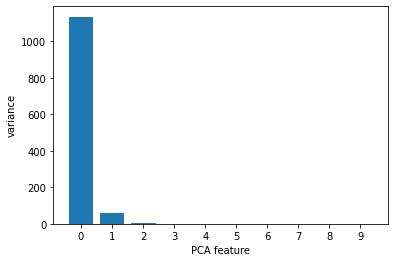

In [12]:
pca = PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Bu bileşenlere, kimi kaynaklarda "içsel boyut" olarak da rastlamanız mümkündür. Bu örnek için, bizim veri kümemiz aslında çok boyutlu bir küme iken, "içsel" olarak aslında 2 boyutludur diyebiliriz.

Burada, özelliklerin ciddi bir bölümünün bilgi içermediğini görüyoruz. Bileşen sayımızı 2 olarak belirlersek, işimize yarayacak bilginin önemli bir bölümünü koruyabiliriz gibi görünüyor. Peki bu "bilgi" dediğimiz büyüklüğün tam olarak ne kadarını koruyoruz?

In [13]:
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.94894308 0.04846474]
0.9974078268453296


Bileşen sayımızı 2 olarak belirlediğimizde, toplam varyansın yaklaşık %99.8'ini, yani neredeyse tamamını koruyabiliyoruz.

In [19]:
pca = PCA(n_components=2)
pca.fit(scaled_x)
pca_features = pca.transform(scaled_x)

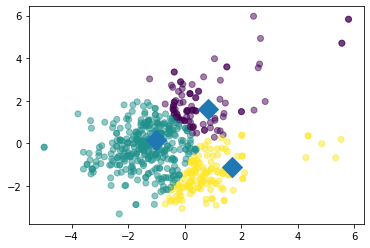

In [20]:
model = KMeans(n_clusters=3)
training_points = pca_features[:1000]
test_points = pca_features[1000:]
model.fit(training_points)
labels = model.predict(test_points)
xs = test_points[:,0]
ys = test_points[:,1]

plt.scatter(xs, ys, c=labels, alpha=0.5)

centroids = model.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

plt.scatter(centroids_x, centroids_y, marker='D',s=200)
plt.show()

Hem ağırlık merkezleri, hem de kümeler kesinlikle ilk denememizde olduğundan daha iyi görünüyor.

## Hiyerarşik Kümeleme

Hiyerarşik kümeleme, örnekleri küçükten büyüğe doğru bir küme hiyerarşisi içerisinde düzenler. Tıpkı lise biyolojisinde gördüğümüz canlılar alemi sınıflandırmasına benzer olarak, en küçük(veya büyük) ortak özelliklerden başlar ve sınıflayarak devam eder.

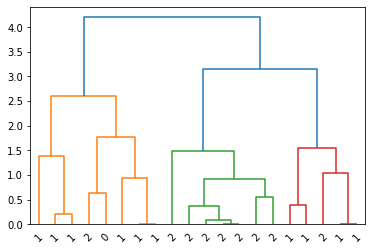

In [26]:
mergings = linkage(test_points[:20], method="complete")

dendrogram(mergings,
           labels=labels[:20],
           leaf_rotation=45,
           leaf_font_size=10,
)
plt.show()

Tam bağlantıda(yukarıdaki linkage metodunda "complete" olarak refere edilmiştir), kümeler arasındaki mesafe, kümelerin en uzak noktaları arasındaki mesafedir. Buna agglomerative(birleştirici) yaklaşım denir. Bu yaklaşımın başlangıcında, tüm nesneler birbirinden ayrıdır. Yani örneklerin her biri kendi başına bir kümedir. Devamında benzer özniteliklere sahip kümeler bir araya getirilerek tek bir küme elde edilir. Bu yöntemin bir diğer adı da **En Uzak Komşu Yöntemi'dir(Furthest Neighbor)**.

Tek bağlantıda(aşağıdaki linkage metodunda "single" olarak refere edilmiştir), kümeler arasındaki mesafe, kümelerin en yakın noktaları arasındaki mesafedir. Bölücü(divisive) yaklaşımda ise ayrıştırıcı bir strateji hakimdir. Bu yaklaşımda başlangıçta tek bir küme vardır. Her aşamada uzaklık/benzerlik matrisine göre nesneler ana kümeden ayrılarak, farklı alt kümeler oluşur. Süreç sonucunda her veri bir küme olur. Bu yöntemin diğer adı da **En Yakın Komşu Yöntemi'dir(Nearest Neighbor)**.

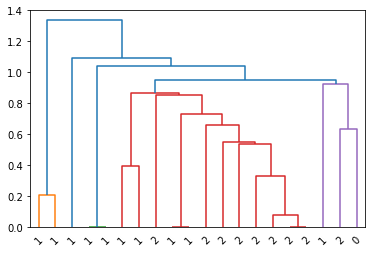

In [25]:
mergings = linkage(test_points[:20], method="single")

dendrogram(mergings,
           labels=labels[:20],
           leaf_rotation=45,
           leaf_font_size=10,
)
plt.show()

Sonraki yazılarımızda görüşmek üzere.